In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import time
from matplotlib import pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score

from dbscan import dbscan

In [2]:
NYC_PREPARED_DATA_PATH = 'data/NYPD_Shooting_Incident_Data_PREPARE.csv'

# Check correct of DBSCAN operation

## First testing dataset

In [5]:
def test(seed_val = 43):
    np.random.seed(seed_val)
    X = np.random.rand(150, 2)
    epsilon = 0.08
    min_samples = 5

    labels = dbscan(X, epsilon, min_samples)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.scatter(X[:, 0], X[:, 1], c='gray', label='Dane przed DBSCAN')
    plt.title('Zbiór przed DBSCAN')
    plt.ylim(0, 1)
    plt.xlim(0, 1)

    plt.subplot(1, 3, 2)
    mask = labels != -1
    plt.scatter(X[mask, 0], X[mask, 1], c=labels[mask], cmap='viridis', label='Jan')
    plt.title('Klastry po DBSCAN Jan')
    plt.ylim(0, 1)
    plt.xlim(0, 1)

    dbscan_sk = DBSCAN(eps=epsilon, min_samples=min_samples)
    labels_sk = dbscan_sk.fit_predict(X)

    plt.subplot(1, 3, 3)
    mask_sk = labels_sk != -1
    plt.scatter(X[mask_sk, 0], X[mask_sk, 1], c=labels_sk[mask_sk], cmap='viridis', label='scikit-learn')
    plt.title('Klastry po DBSCAN Scikit')
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.show()

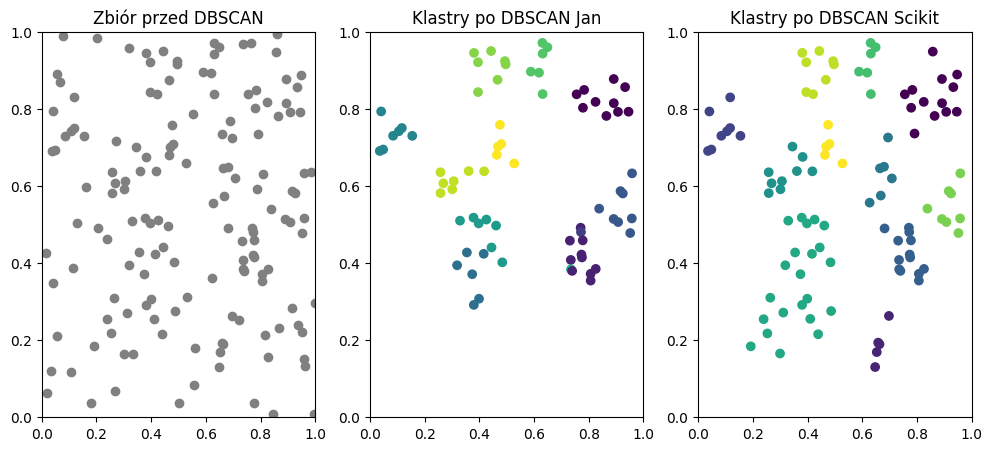

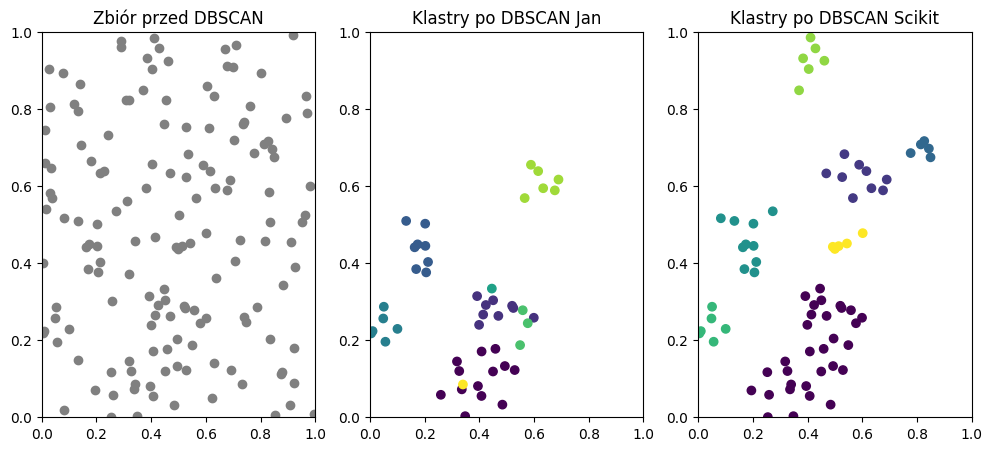

In [6]:
test(20)
test(40)\

## Second testing dataset

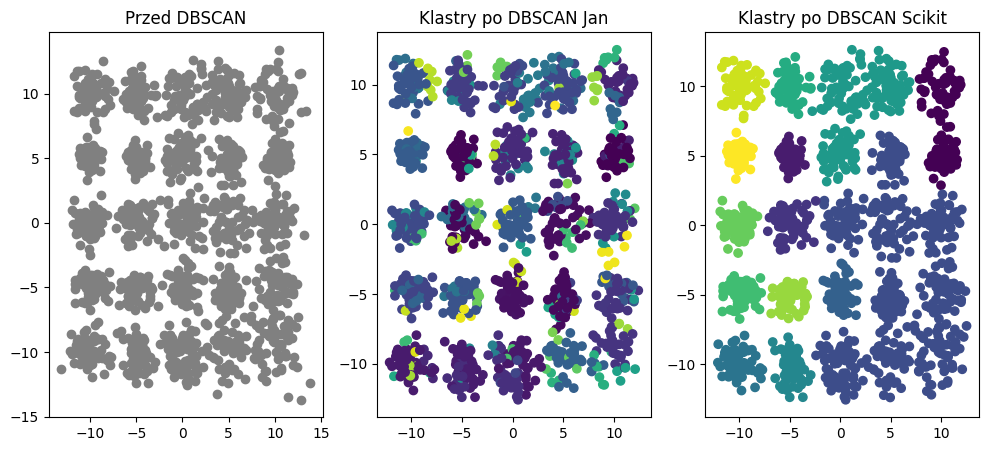

In [43]:
def test_2(seed_val=43, n_samples=1500, centers=10, cluster_std=0.5):
    np.random.seed(seed_val)
    X, _ = make_blobs(n_samples=n_samples, centers=centers, cluster_std=cluster_std)

    epsilon = 0.7
    min_samples = 7

    labels = dbscan(X, epsilon, min_samples)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.scatter(X[:, 0], X[:, 1], c='gray', label='Dane przed DBSCAN')
    plt.title('Zbiór przed DBSCAN')

    plt.subplot(1, 3, 2)
    mask = labels != -1
    plt.scatter(X[mask, 0], X[mask, 1], c=labels[mask], cmap='viridis', label='Jan')
    plt.title('Klastry po DBSCAN Jan')

    dbscan_sk = DBSCAN(eps=epsilon, min_samples=min_samples)
    labels_sk = dbscan_sk.fit_predict(X)

    plt.subplot(1, 3, 3)
    mask_sk = labels_sk != -1
    plt.scatter(X[mask_sk, 0], X[mask_sk, 1], c=labels_sk[mask_sk], cmap='viridis', label='scikit-learn')
    plt.title('Klastry po DBSCAN Scikit')
    plt.show()

test(centers=[(x, y) for x in np.linspace(-10, 10, 5) for y in np.linspace(-10, 10, 5)], cluster_std=[np.random.uniform(0.5, 1.5) for _ in range(25)]) # centers = groups centers, cluster_std = standard deviations for groups

# Read and check data

In [7]:
nyc_df = pd.read_csv(NYC_PREPARED_DATA_PATH)

In [8]:
nyc_df

,incident_k,date_occur,time_occur,occur_time,boro,loc_of_occ,precinct,loc_classf,location_d,statistica,...,vic_age_gr,vic_sex,vic_race,latitude,longitude,geometry,year,month,day,weekday
0,228798151,2021-05-27,00:00:00.000,21:30:00,QUEENS,NaN,105.0,NaN,NaN,F,...,18-24,M,BLACK,40.662965,-73.730839,POINT (-73.73083868899994 40.662964620000025),2021,5,27,3
1,137471050,2014-06-27,00:00:00.000,17:40:00,BRONX,NaN,40.0,NaN,NaN,F,...,18-24,M,BLACK,40.810352,-73.924942,POINT (-73.92494232599995 40.81035186300006),2014,6,27,4
2,147998800,2015-11-21,00:00:00.000,03:56:00,QUEENS,NaN,108.0,NaN,NaN,T,...,25-44,M,WHITE,40.742607,-73.915492,POINT (-73.91549174199997 40.74260663300004),2015,11,21,5
3,146837977,2015-10-09,00:00:00.000,18:30:00,BRONX,NaN,44.0,NaN,NaN,F,...,<18,M,WHITE HISPANIC,40.837782,-73.919457,POINT (-73.91945661499994 40.83778200300003),2015,10,9,4
4,58921844,2009-02-19,00:00:00.000,22:58:00,BRONX,NaN,47.0,NaN,NaN,T,...,45-64,M,BLACK,40.886238,-73.852910,POINT (-73.85290950899997 40.88623791800006),2009,2,19,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27293,245029823,2022-05-14,00:00:00.000,03:02:00,BRONX,OUTSIDE,48.0,STREET,(null),F,...,18-24,M,BLACK,40.846864,-73.901413,POINT (-73.90141321 40.84686352),2022,5,14,5
27294,239583450,2022-01-22,00:00:00.000,13:15:00,MANHATTAN,OUTSIDE,30.0,STREET,(null),F,...,25-44,M,WHITE HISPANIC,40.826743,-73.952273,POINT (-73.952273 40.826743),2022,1,22,5
27295,246825728,2022-06-18,00:00:00.000,03:29:00,MANHATTAN,OUTSIDE,32.0,STREET,(null),F,...,25-44,M,BLACK,40.810209,-73.939496,POINT (-73.9394955 40.81020941),2022,6,18,5
27296,246876579,2022-06-19,00:00:00.000,20:08:00,BRONX,INSIDE,46.0,HOUSING,MULTI DWELL - PUBLIC HOUS,F,...,25-44,M,WHITE HISPANIC,40.855644,-73.896141,POINT (-73.896141 40.855644),2022,6,19,6


In [9]:
missing_values = nyc_df[['latitude', 'longitude','vic_age_gr']].isnull().sum()
missing_values

latitude      0
longitude     0
vic_age_gr    0
dtype: int64

In [11]:
nyc_df = nyc_df.dropna(subset=['longitude', 'latitude','vic_age_gr'])

# Run DBSCAN for latitude and longitude columns

In [17]:
clean_coords = nyc_df[['latitude', 'longitude']].to_numpy()

In [14]:
eps_values = np.arange(0.001, 0.027, 0.005)  # Possible epsilon values
min_samples_values = range(5, 25, 5)  # Possible minimum sample values
eps_values

array([0.001, 0.006])

Function for printing results

In [19]:
def plot_dbscan_clusters(df, lat_col, lon_col, cluster_col, title = 'Grupowanie DBSCAN dla zbioru NYPD Shooting Incidents dla kolumn long/lat', show_noise=True):
    """
    Plots the clusters obtained from DBSCAN.

    Parameters:
    df (DataFrame): The dataframe containing the cluster data.
    lat_col (str): The name of the column containing latitude values.
    lon_col (str): The name of the column containing longitude values.
    cluster_col (str): The name of the column containing cluster labels.
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Plotting each cluster with a different color
    labels = df[cluster_col].unique()
    for label in labels:
        if label == -1 and not show_noise:
            continue  # Skip noise points

        cluster_data = df[df[cluster_col] == label]
        if label == -1:  # Plot noise points in black
            ax.scatter(cluster_data[lon_col], cluster_data[lat_col], c='k', label='Noise', s=10, alpha=0.5)
        else:
            ax.scatter(cluster_data[lon_col], cluster_data[lat_col], label=f'Cluster {label}', s=10)

    ax.set_title(title)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    # ax.legend()
    plt.show()

## Jan DBSCAN

## Scikit DBSCAN

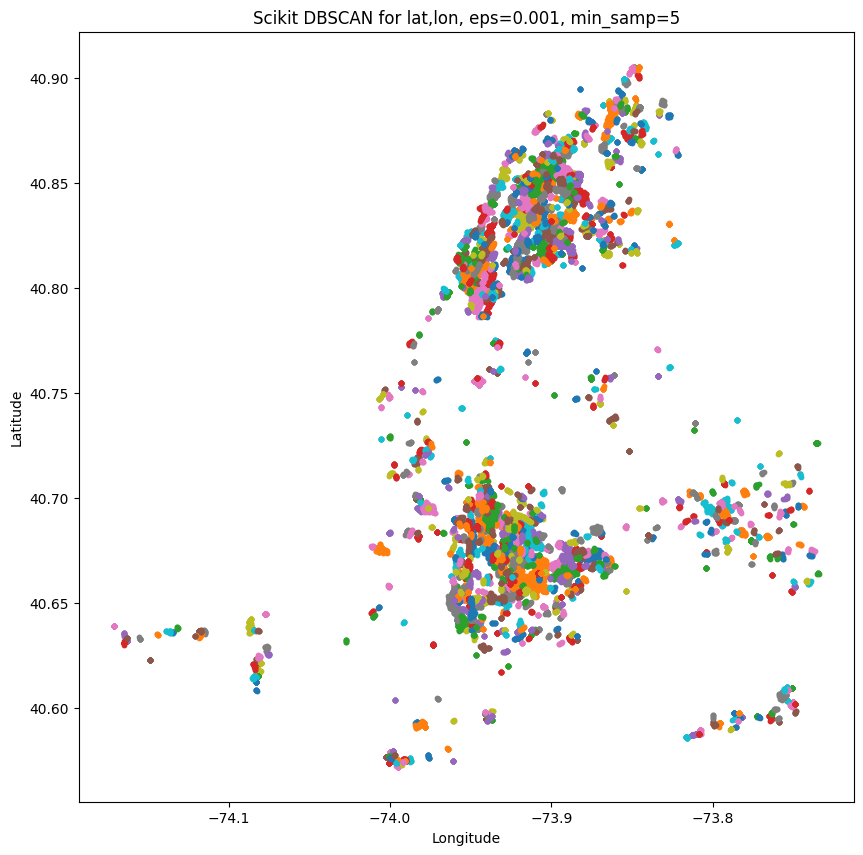

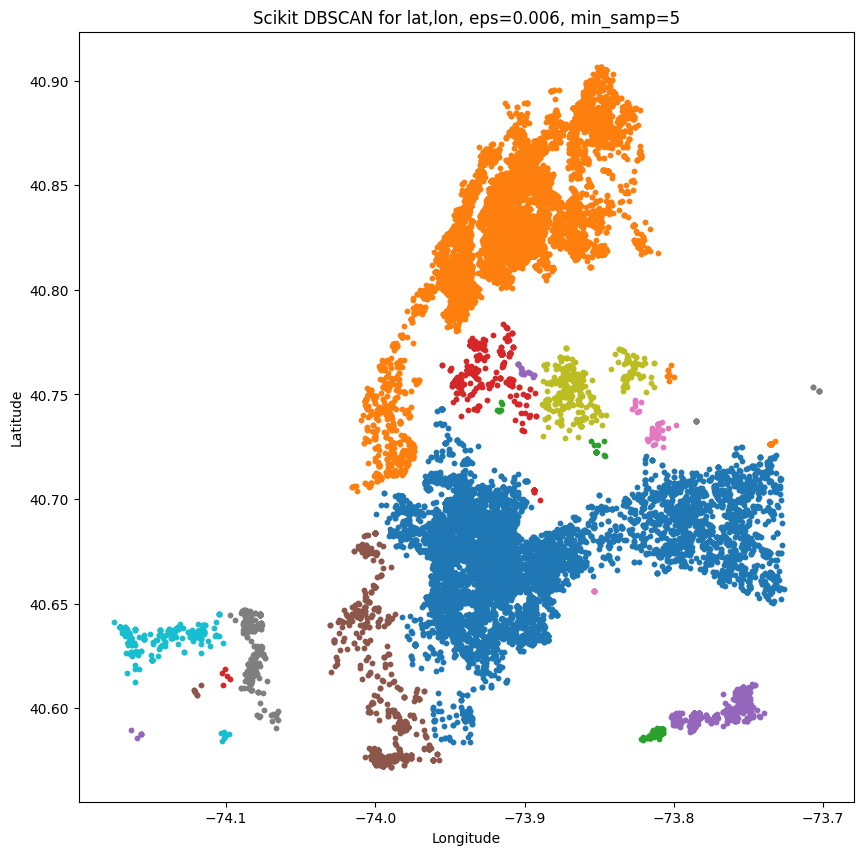

In [29]:
eps_test = []
min_samples_test = []
silhouette_test = []
groups_amount = []
execution_time = []

for eps in eps_values:
    for min_samples in min_samples_values:
        start_time = time.time()
        db_sk = DBSCAN(eps=eps, min_samples=min_samples).fit(clean_coords)
        end_time = time.time()
        elapsed_time = end_time - start_time

        nyc_df['cluster'] = db_sk.labels_
        plot_dbscan_clusters(nyc_df, 'latitude', 'longitude', 'cluster',title=f"Scikit DBSCAN for lat,lon, eps={eps}, min_samp={min_samples}", show_noise=False)

        sil_score = silhouette_score(clean_coords, db_sk.labels_)
        eps_test.append(eps)
        min_samples_test.append(min_samples)
        groups_amount.append(len(set(db_sk.labels_)))
        execution_time.append(elapsed_time)
        silhouette_test.append(sil_score)

        nyc_df.drop('cluster', axis=1, inplace=True)

scikit_dbscan_results = np.column_stack((eps_test, min_samples_test, groups_amount, execution_time, silhouette_test))

In [30]:
scikit_dbscan_results

array([[ 1.00000000e-03,  5.00000000e+00,  1.14200000e+03,
         1.14098549e-01,  7.18641884e-02],
       [ 6.00000000e-03,  5.00000000e+00,  2.90000000e+01,
         2.51716375e-01, -4.90193763e-02]])

# Experiments for specific date

## Scikit DBSCAN

In [46]:
years_to_test = [2008, 2013, 2018, (2021, 2022)]
results = []

for years in years_to_test:
    if isinstance(years, tuple):  # for range
        mask = nyc_df['year'].between(years[0], years[1])
    else:  # specific date
        mask = nyc_df['year'] == years

    filtered_data = nyc_df[mask]
    clean_coords = filtered_data[['latitude', 'longitude']]

    eps = 0.01
    min_samples = 5

    start_time = time.time()
    db_sk = DBSCAN(eps=eps, min_samples=min_samples).fit(clean_coords)
    end_time = time.time()
    elapsed_time = end_time - start_time

    num_clusters = len(set(db_sk.labels_)) - (1 if -1 in db_sk.labels_ else 0)
    num_points = clean_coords.shape[0]
    results.append({
        'years': years,
        'elapsed_time': elapsed_time,
        'num_clusters': num_clusters,
        'num_noise_points': list(db_sk.labels_).count(-1),
        'num_points': num_points
    })

results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by='num_points', ascending=True)
print(results_df_sorted)

          years  elapsed_time  num_clusters  num_noise_points  num_points
2          2018      0.003504            17                98         958
1          2013      0.005503            21                84        1338
0          2008      0.009508            27                63        1959
3  (2021, 2022)      0.018516            18                89        3716


# BASE  EXPERIMENTS

# DBSCAN from API analyze only coords (works only with latitude and longitude)

In [7]:
clean_coords = nyc_df[['latitude', 'longitude']].to_numpy()

In [8]:
clean_coords

array([[ 40.66296462, -73.73083869],
       [ 40.81035186, -73.92494233],
       [ 40.74260663, -73.91549174],
       ...,
       [ 40.81020941, -73.9394955 ],
       [ 40.855644  , -73.896141  ],
       [ 40.837102  , -73.847134  ]])

In [9]:
# Define the range of parameters for the experiment
eps_values = np.arange(0.001, 0.027, 0.005)  # Possible epsilon values
min_samples_values = range(5, 20, 5)  # Possible minimum sample values

In [10]:
eps_values

array([0.001, 0.006, 0.011, 0.016, 0.021, 0.026])

In [35]:
# Variables to store the best parameters and the best silhouette score
best_eps = None
best_min_samples = None
best_silhouette = -1

# Perform grid search
for eps in eps_values:
    for min_samples in min_samples_values:
        # Apply DBSCAN
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(clean_coords)
        if len(set(db.labels_)) > 1:  # Silhouette_score cannot be calculated with a single cluster
            sil_score = silhouette_score(clean_coords, db.labels_)
            # Check if this is the best silhouette score so far
            if sil_score > best_silhouette:
                best_eps = eps
                best_min_samples = min_samples
                best_silhouette = sil_score

(best_eps, best_min_samples, best_silhouette)

(0.026000000000000002, 5, 0.3466068330042389)

In [11]:
# Reinitialize and fit the DBSCAN model with clean data
db_clean = DBSCAN(eps=0.0025, min_samples=15).fit(clean_coords)
# db_clean = DBSCAN(eps=0.026000000000000002, min_samples=5).fit(clean_coords)

# Assign cluster labels to the clean dataframe
nyc_df['cluster'] = db_clean.labels_

# Overview of the cluster distribution in the cleaned data
clean_cluster_distribution = nyc_df['cluster'].value_counts()
clean_cluster_distribution.head()

cluster
 2    8392
 0    5321
-1    3612
 4    2821
 1     681
Name: count, dtype: int64

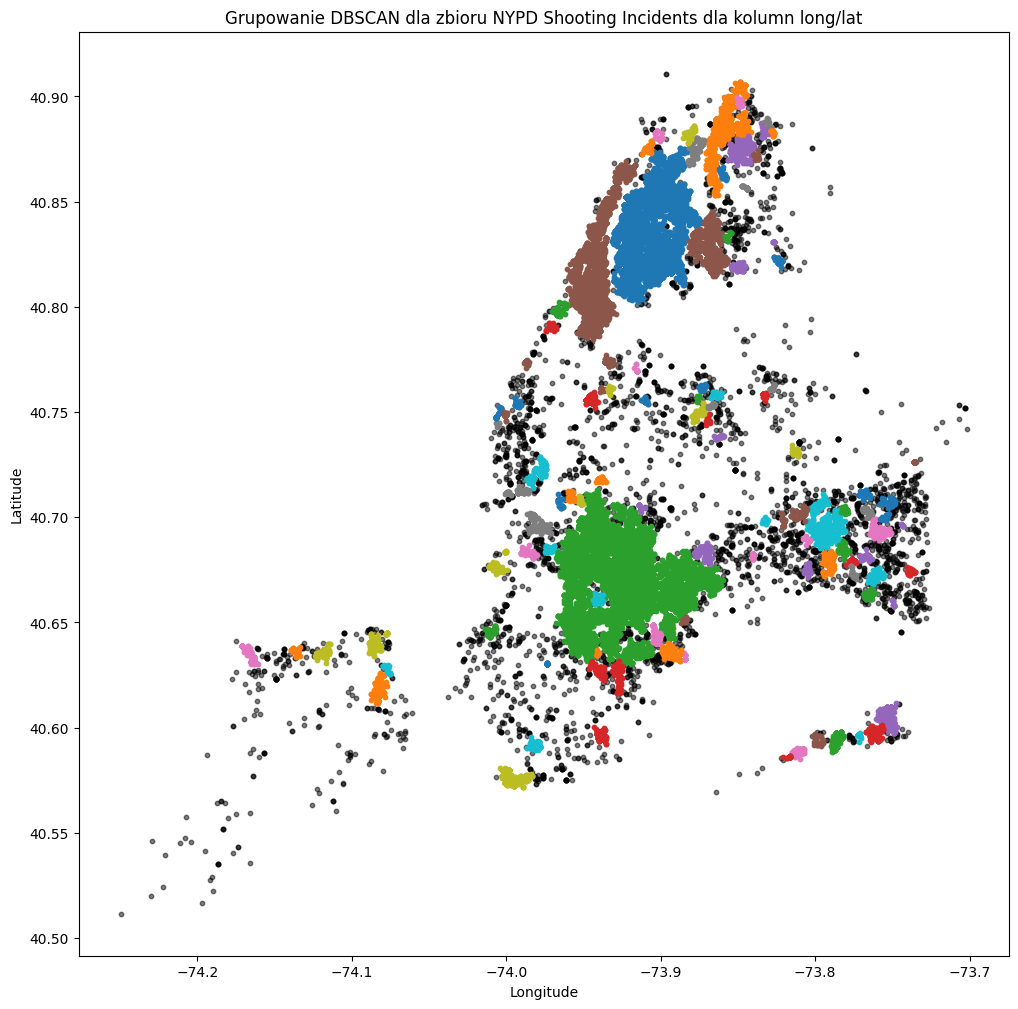

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Plotting each cluster with a different color
labels = nyc_df['cluster'].unique()
for label in labels:
    cluster_data = nyc_df[nyc_df['cluster'] == label]
    if label == -1:
        # Plot noise points in black
        ax.scatter(cluster_data['longitude'], cluster_data['latitude'], c='k', label=f'Noise', s=10, alpha=0.5)
    else:
        ax.scatter(cluster_data['longitude'], cluster_data['latitude'], label=f'Cluster {label}', s=10)

ax.set_title('Grupowanie DBSCAN dla zbioru NYPD Shooting Incidents dla kolumn long/lat')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
# plt.legend()
plt.show()

# DBSCAN from API analyze coords with one more column

In [13]:
clean_coords_with_vic_age_col = nyc_df[['latitude', 'longitude','vic_age_gr']].to_numpy()

In [14]:
np.unique(clean_coords_with_vic_age_col[:,2])

array(['18-24', '25-44', '45-64', '65+', '<18', 'UNKNOWN'], dtype=object)

Change string values to float (mapping)

In [15]:
age_group_mapping = {'<18': 0, '18-24': 1, '25-44': 2, '45-64': 3, '65+': 4,'UNKNOWN': 5}
mapping_function = np.vectorize(lambda x: age_group_mapping.get(x, x))
clean_coords_with_vic_age_col_mapped = mapping_function(clean_coords_with_vic_age_col)

In [16]:
# Reinitialize and fit the DBSCAN model with clean data
db_clean_3cols = DBSCAN(eps=0.0025, min_samples=15).fit(clean_coords_with_vic_age_col_mapped)
# db_clean = DBSCAN(eps=0.026000000000000002, min_samples=5).fit(clean_coords)

# Assign cluster labels to the clean dataframe
nyc_df['cluster'] = db_clean_3cols.labels_

# Overview of the cluster distribution in the cleaned data
clean_cluster_distribution = nyc_df['cluster'].value_counts()
clean_cluster_distribution.head()

cluster
-1     11429
 2      2267
 7      1966
 0      1562
 10     1002
Name: count, dtype: int64

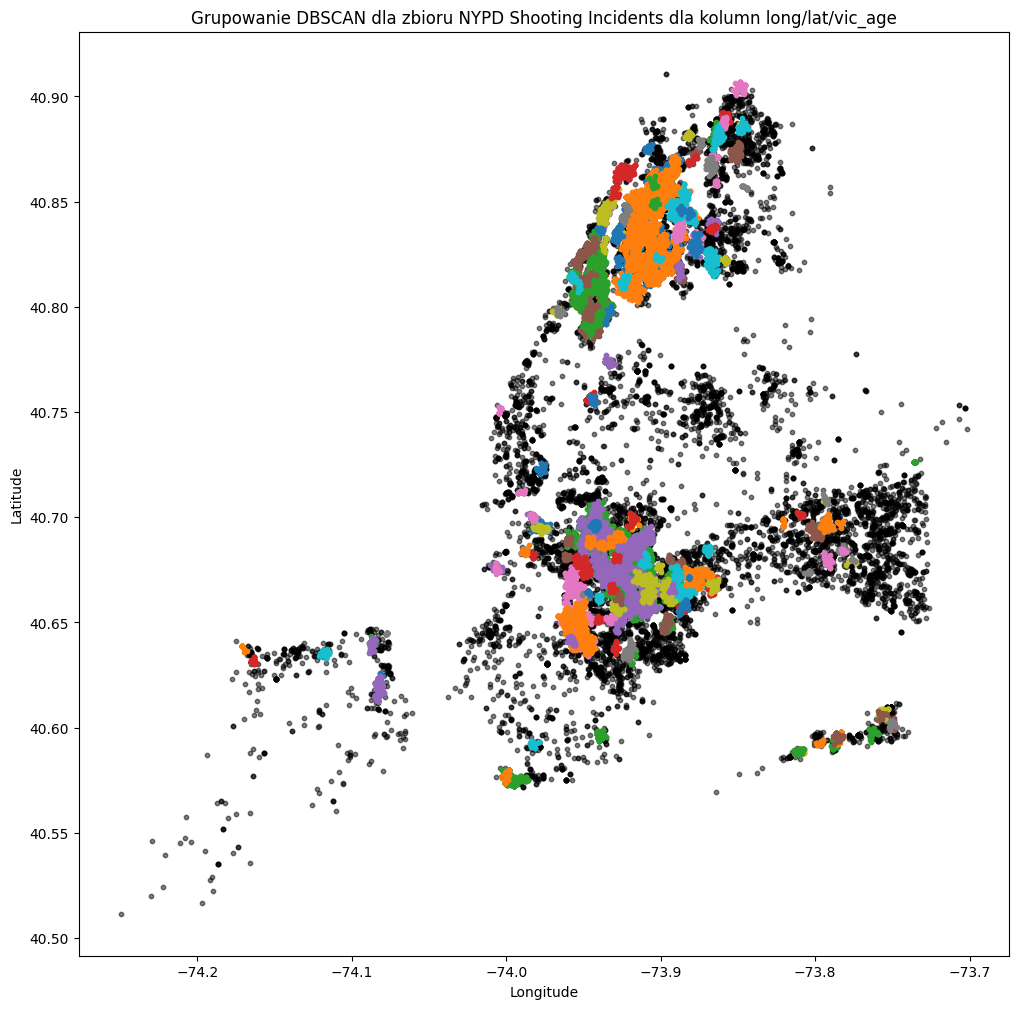

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

labels = nyc_df['cluster'].unique()
for label in labels:
    cluster_data = nyc_df[nyc_df['cluster'] == label]
    if label == -1:
        # Plot noise points in black
        ax.scatter(cluster_data['longitude'], cluster_data['latitude'], c='k', label=f'Noise', s=10, alpha=0.5)
    else:
        ax.scatter(cluster_data['longitude'], cluster_data['latitude'], label=f'Cluster {label}', s=10)

ax.set_title('Grupowanie DBSCAN dla zbioru NYPD Shooting Incidents dla kolumn long/lat/vic_age')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
# plt.legend()

# Display the plot
plt.show()

# Test my DBSCAN

In [25]:
from dbscan import dbscan
from dbscan_v2 import dbscan as dbscan_v2

In [20]:
clean_coords

array([[ 40.66296462, -73.73083869],
       [ 40.81035186, -73.92494233],
       [ 40.74260663, -73.91549174],
       ...,
       [ 40.81020941, -73.9394955 ],
       [ 40.855644  , -73.896141  ],
       [ 40.837102  , -73.847134  ]])

In [21]:
labels = dbscan(clean_coords, epsilon=0.0025, min_samples=15)

In [33]:
unique_values, counts = np.unique(labels, return_counts=True)

# Wyświetlenie unikalnych wartości i ich liczebności
for value, count in zip(unique_values, counts):
    print(f'Wartość: {value}, Liczebność: {count}')

Wartość: -1, Liczebność: 4322
Wartość: 1, Liczebność: 110
Wartość: 2, Liczebność: 103
Wartość: 3, Liczebność: 19
Wartość: 4, Liczebność: 49
Wartość: 5, Liczebność: 46
Wartość: 6, Liczebność: 46
Wartość: 7, Liczebność: 95
Wartość: 8, Liczebność: 28
Wartość: 9, Liczebność: 52
Wartość: 10, Liczebność: 37
Wartość: 11, Liczebność: 32
Wartość: 12, Liczebność: 32
Wartość: 13, Liczebność: 41
Wartość: 14, Liczebność: 148
Wartość: 15, Liczebność: 37
Wartość: 16, Liczebność: 50
Wartość: 17, Liczebność: 28
Wartość: 18, Liczebność: 25
Wartość: 19, Liczebność: 94
Wartość: 20, Liczebność: 39
Wartość: 21, Liczebność: 44
Wartość: 22, Liczebność: 36
Wartość: 23, Liczebność: 29
Wartość: 24, Liczebność: 24
Wartość: 25, Liczebność: 117
Wartość: 26, Liczebność: 28
Wartość: 27, Liczebność: 115
Wartość: 28, Liczebność: 28
Wartość: 29, Liczebność: 70
Wartość: 30, Liczebność: 60
Wartość: 31, Liczebność: 181
Wartość: 32, Liczebność: 63
Wartość: 33, Liczebność: 25
Wartość: 34, Liczebność: 20
Wartość: 35, Liczebno

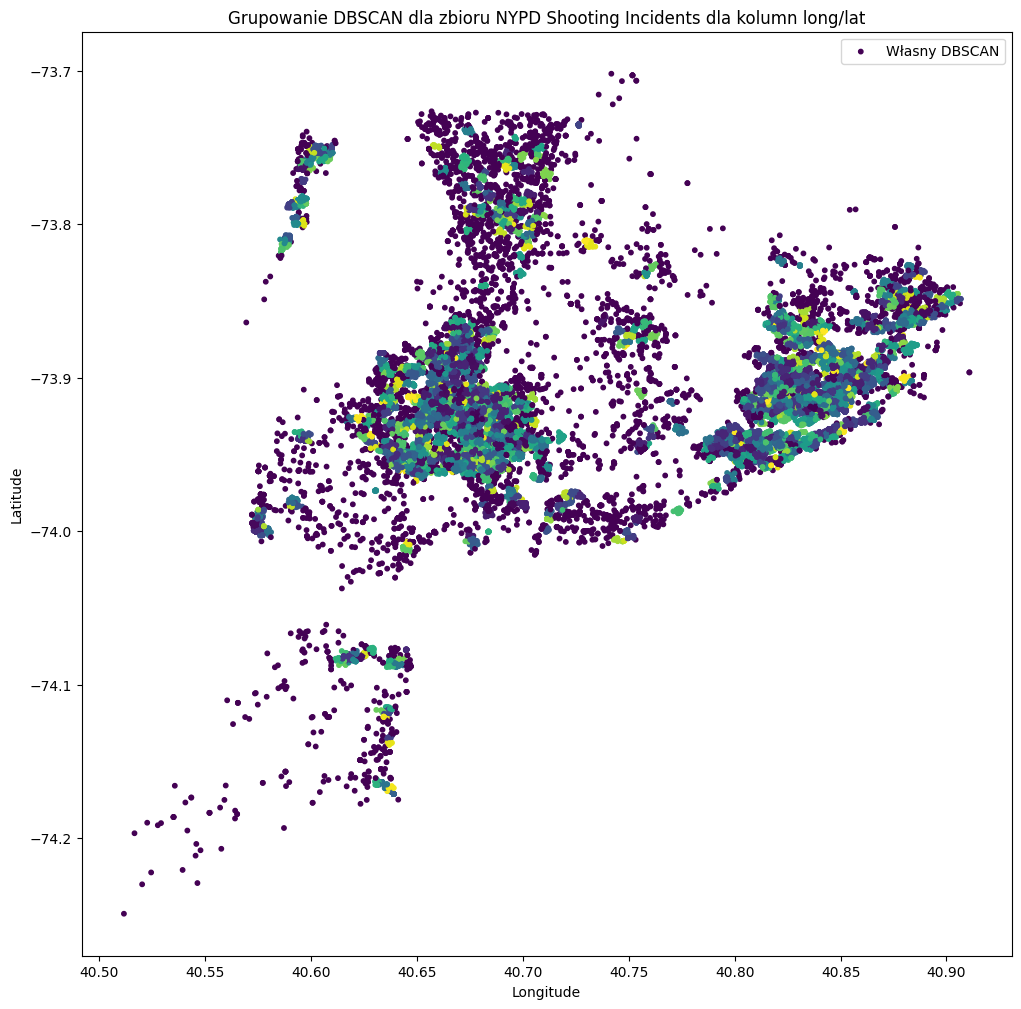

In [32]:
plt.figure(figsize=(12, 12))
plt.scatter(clean_coords[:, 0], clean_coords[:, 1], c=labels, cmap='viridis', label='Własny DBSCAN', s=10)

# Tytuł i oznaczenia osi
plt.title('Grupowanie DBSCAN dla zbioru NYPD Shooting Incidents dla kolumn long/lat')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

In [26]:
labels_v2 = dbscan_v2(clean_coords, epsilon=0.0025, min_samples=15)

In [30]:
unique_values, counts = np.unique(labels_v2, return_counts=True)

# Wyświetlenie unikalnych wartości i ich liczebności
for value, count in zip(unique_values, counts):
    print(f'Wartość: {value}, Liczebność: {count}')

Wartość: -1, Liczebność: 3921
Wartość: 1, Liczebność: 5315
Wartość: 2, Liczebność: 678
Wartość: 3, Liczebność: 8260
Wartość: 4, Liczebność: 117
Wartość: 5, Liczebność: 2821
Wartość: 6, Liczebność: 93
Wartość: 7, Liczebność: 232
Wartość: 8, Liczebność: 249
Wartość: 9, Liczebność: 344
Wartość: 10, Liczebność: 35
Wartość: 11, Liczebność: 165
Wartość: 12, Liczebność: 183
Wartość: 13, Liczebność: 78
Wartość: 14, Liczebność: 26
Wartość: 15, Liczebność: 623
Wartość: 16, Liczebność: 49
Wartość: 17, Liczebność: 89
Wartość: 18, Liczebność: 96
Wartość: 19, Liczebność: 30
Wartość: 20, Liczebność: 25
Wartość: 21, Liczebność: 95
Wartość: 22, Liczebność: 187
Wartość: 23, Liczebność: 23
Wartość: 24, Liczebność: 23
Wartość: 25, Liczebność: 127
Wartość: 26, Liczebność: 81
Wartość: 27, Liczebność: 55
Wartość: 28, Liczebność: 86
Wartość: 29, Liczebność: 17
Wartość: 30, Liczebność: 17
Wartość: 31, Liczebność: 31
Wartość: 32, Liczebność: 28
Wartość: 33, Liczebność: 60
Wartość: 34, Liczebność: 28
Wartość: 35

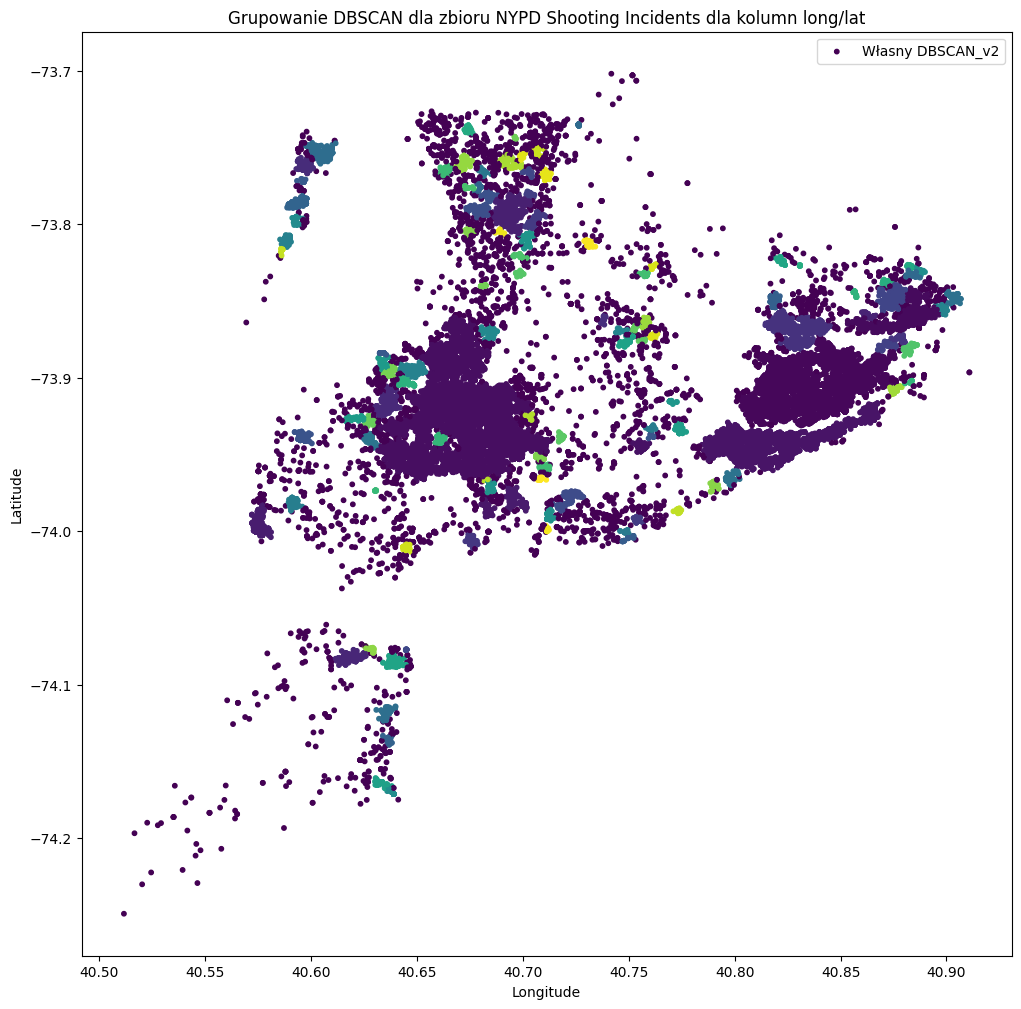

In [31]:
plt.figure(figsize=(12, 12))
plt.scatter(clean_coords[:, 0], clean_coords[:, 1], c=labels_v2, cmap='viridis', label='Własny DBSCAN_v2', s=10)

plt.title('Grupowanie DBSCAN dla zbioru NYPD Shooting Incidents dla kolumn long/lat')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.legend()
plt.show()

Dodac usuniecie szumu i nałozenie utworzonych grup na okregi policyjne. Plus dodac tworzenie sie grup dla danych z danego roku i uzyc tez tego do porownania czasu liczenia sie dla kazdej grupy (ze licznosc grupy i czas dzialania) plus porownac wyniki z oryginalnym kodem. Sprawdzenie czy algorytm dziala dla malego randomowego zbioru danych